# TEgenomeSimulator Approximate Bayesian Computation

This tutorial will cover the use of Approximate Bayesian Computation on TEgenomeSimulator for Bayesian calibration of stochastic computer simulation models. 

Bayesian calibration of computer simulation models is a method to update uncertain model parameters using observed data and prior knowledge, producing a posterior distribution that reflects parameter uncertainty. It treats the simulator as a probabilistic function, often incorporating a discrepancy term to account for model–reality differences. This approach allows quantified predictions and uncertainty propagation in the model outputs. [A useful text on Bayesian calibration may be found here](https://rss.onlinelibrary.wiley.com/doi/abs/10.1111/1467-9868.00294). 

# Imports

We will first import all required dependencies and specify our constants.

In [1]:
from subprocess import Popen
import subprocess
from pathlib import Path
import numpy as np
from sourmash import MinHash
from sourmash import signature as sig
from Bio import SeqIO
import pandas as pd
import numpy as np
import os.path as osp
import shutil

from calisim.data_model import (
	DistributionModel,
	ParameterDataType,
	ParameterSpecification,
)
from calisim.abc import (
	ApproximateBayesianComputationMethod,
	ApproximateBayesianComputationMethodModel,
)
from calisim.statistics import L2Norm

M = 0
c=str(Path("data", "random_genome_chr_index.csv"))
r=str(Path("data", "combined_curated_TE_lib_ATOSZM_selected.fasta"))
o="data"
a=0.7
b=0.5
i=0.001
m=3
n=3
ksize = 51 
scaled = 100  
track_abundance = True
seed = 100

# Calibration procedure

## Bayesian calibration

[We will use Approximate Bayesian Computation (ABC) Sequential Monte Carlo to calibrate the model](https://academic.oup.com/book/54037/chapter-abstract/422208917?redirectedFrom=fulltext). ABC aims to minimise the discrepancy between observed and simulated data up to a tolerance threshold (epsilon). Larger values of epsilon will result in faster model calibration with fewer rejections of the forward model outputs but less precise estimates. Smaller values of epsilon will result in slower model calibration with more rejections of the forward model outputs but more precise estimates.

For this exercise, there are four parameters of interest within TEgenomeSimulator: 

- **maxidn**: The upper bound of mean sequence identity to be sampled for each TE family (default is 95; i.e. 95 percent).
- **minidn**: The lower bound of mean sequence identity to be sampled for each TE family (default is 80; i.e. 80 percent).
- **maxsd**:  The upper bound of standard deviation of mean identity to be sampled for each TE family (default is 20).
- **minsd**: The lower bound of standard deviation of mean identity to be sampled for each TE family (default is 1).

# Reference simulation

We will execute a reference simulation where the ground-truth parameters are known.

```python
maxidn=95
minidn=80
maxsd=20
minsd=1
```

In [2]:
maxidn=95
minidn=80
maxsd=20
minsd=1

p="reference_simulation"
cmd = f"tegenomesimulator -M {M} -p {p} -c {c} -r {r} -o {o} -a {a} -b {b} -i {i} -m {m} -n {n} --maxidn {maxidn} --minidn {minidn} --maxsd {maxsd} --minsd {minsd} -s {seed}"
Popen(cmd, shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL).wait()

0

## Sourmash

[Sourmash is a Python library for fast, scalable comparison of DNA, RNA, or protein sequences using MinHash sketches](https://sourmash.readthedocs.io/en/latest/). It allows efficient similarity searches, taxonomic classification, and large-scale genomic data analysis without needing full sequence alignments. By compressing sequences into small, representative sketches, sourmash enables rapid comparisons across thousands of genomes or metagenomes.

We'll use Sourmash to probabilistically encode and compare our simulated genome sequences using k-mers encoding and their subsequent MinHash sketches.

In [3]:
reference_genome_sequence_path = f"{o}/TEgenomeSimulator_{p}_result/{p}_genome_sequence_out_final.fasta"

mh = MinHash(n=0, ksize=ksize, scaled=scaled, track_abundance=track_abundance, seed=seed)
for record in SeqIO.parse(reference_genome_sequence_path, "fasta"):
    mh.add_sequence(str(record.seq), force=True)
reference_encoded_genome_sequence = sig.SourmashSignature(mh, name="reference_genome")
reference_encoded_genome_sequence

SourmashSignature('reference_genome', 945a20e9)

We next construct the parameter specification for Bayesian calibration. We'll treat our parameters as discrete uniform distributions.

In [4]:
parameter_spec = ParameterSpecification(
    parameters=[
        DistributionModel(
            name="maxidn",
            distribution_name="uniform",
            distribution_args=[93, 97],
            data_type=ParameterDataType.DISCRETE,
        ),
        DistributionModel(
            name="minidn",
            distribution_name="uniform",
            distribution_args=[78, 82],
            data_type=ParameterDataType.DISCRETE,
        ),
        DistributionModel(
            name="maxsd",
            distribution_name="uniform",
            distribution_args=[18, 22],
            data_type=ParameterDataType.DISCRETE,
        )
    ]
)

We'll next define the ABC function. We'll use the Jaccard distance as our metric to quantify the discrepancy between the observed and simulated data. The Jaccard similarity measures the similarity between two sets $A$ and $B$:

$$
J(A, B) = \frac{|A \cap B|}{|A \cup B|}
$$

where:

- $0$: no overlap  
- $1$: identical sets  

This is sometimes expressed as a distance metric, as is in this case:  

$$
d_J(A, B) = 1 - J(A, B)
$$

[Here's a quick tutorial on how sourmash uses the Jaccard similarity metric with k-mers encoding and hashing under the hood](https://sourmash.readthedocs.io/en/latest/kmers-and-minhash.html).

ABC.History INFO: Start <ABCSMC id=1, start_time=2025-10-10 06:18:31>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 9.72036424e-01.
ABC INFO: Accepted: 5 / 11 = 4.5455e-01, ESS: 5.0000e+00.
ABC.Adaptation INFO: Change nr particles 5 -> 10
ABC INFO: Stop: Minimum epsilon.
ABC.History INFO: Done <ABCSMC id=1, duration=0:02:23.365881, end_time=2025-10-10 06:20:54>


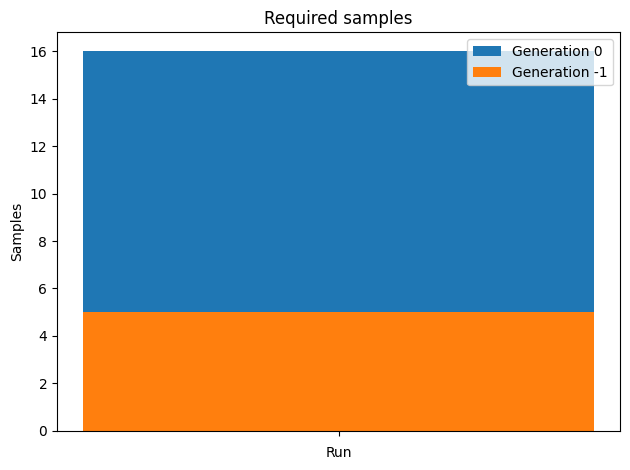

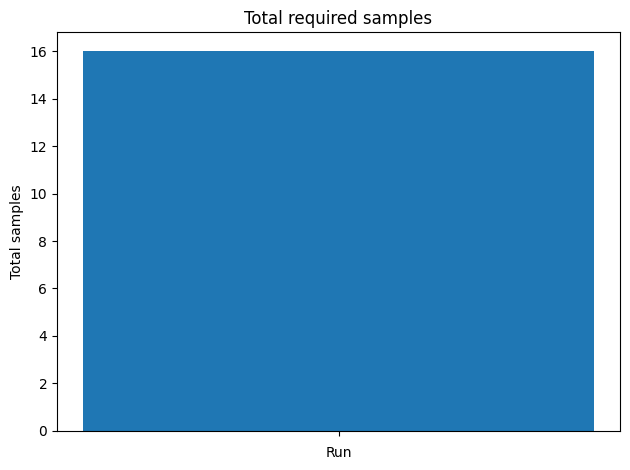

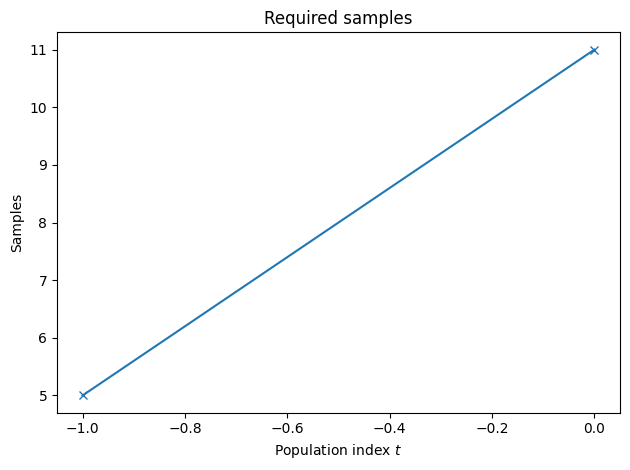

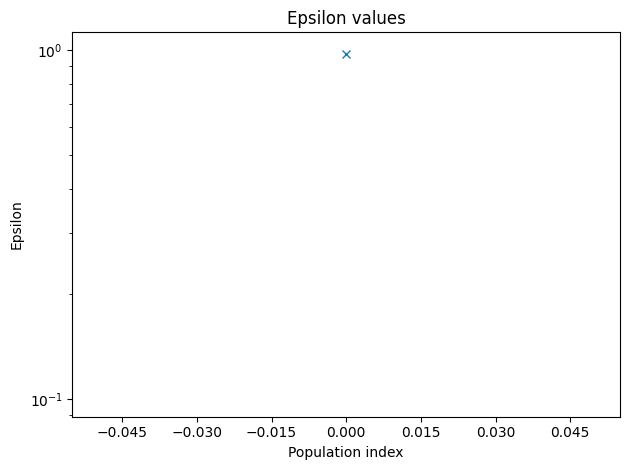

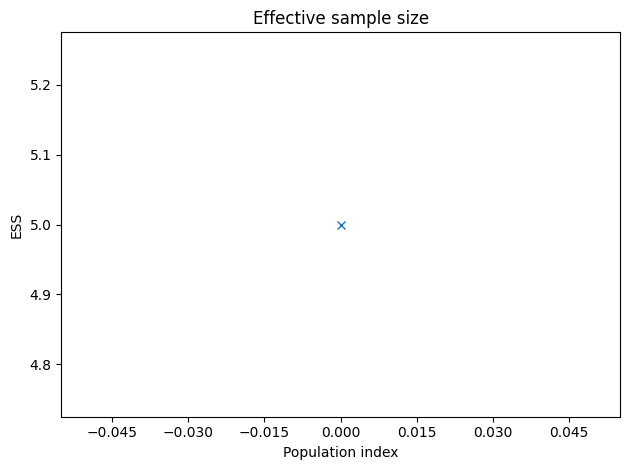

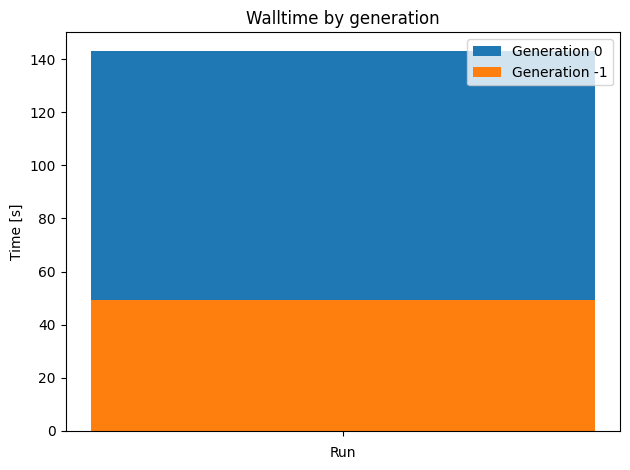

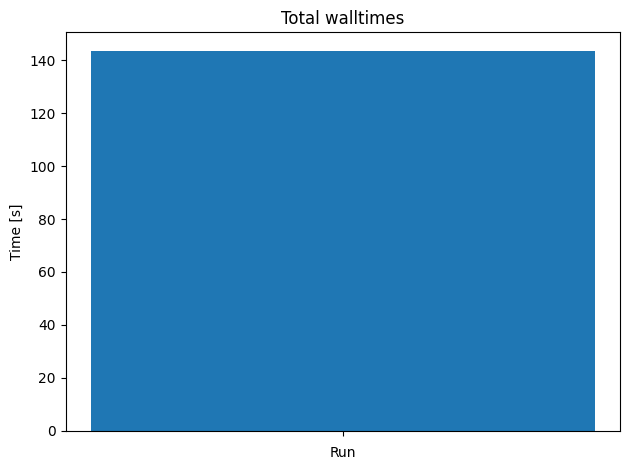

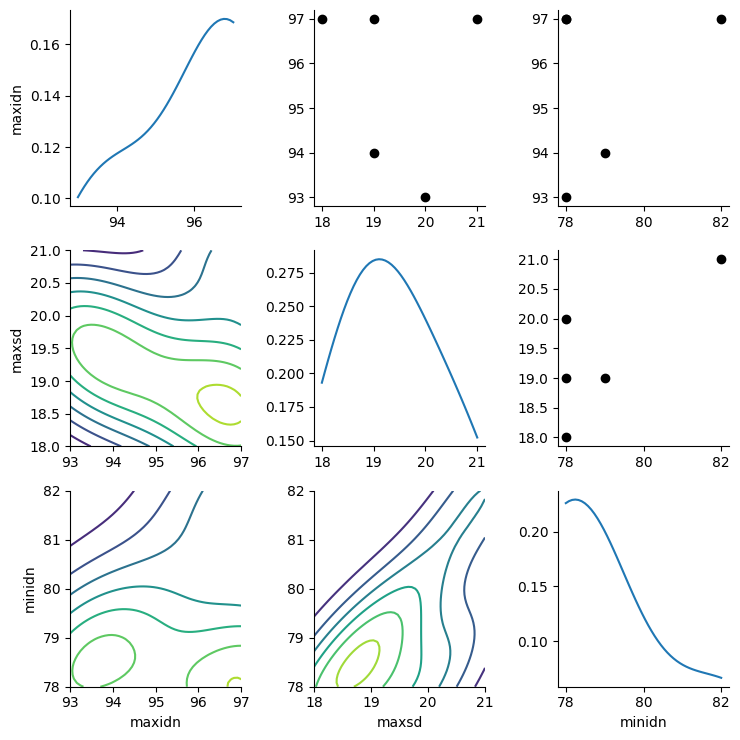

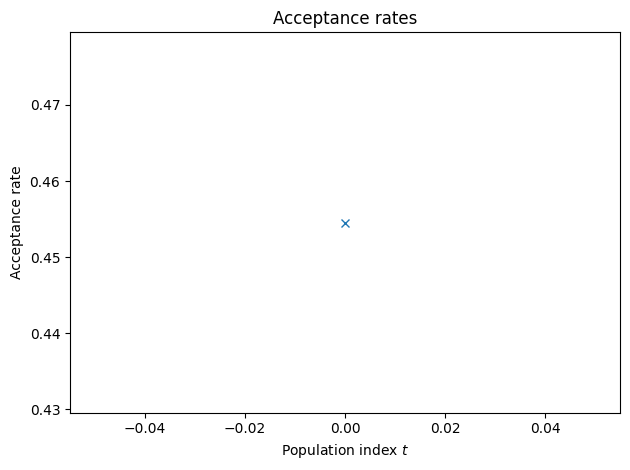

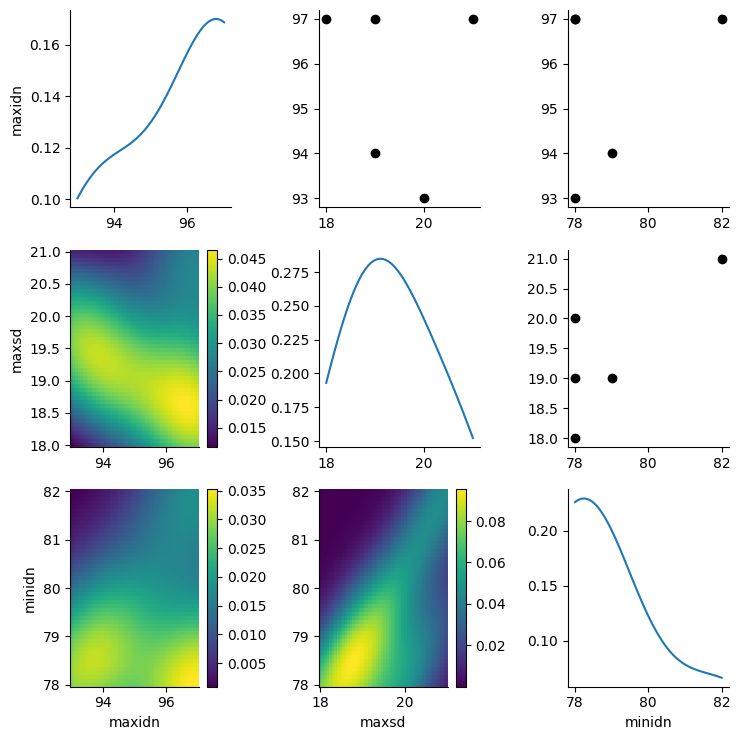

In [5]:
def abc_func(
    parameters: dict, simulation_id: str, observed_data: np.ndarray | None
) -> float | list[float]:
    simulation_parameters = {}
    
    maxidn=parameters["maxidn"]
    minidn=parameters["minidn"]
    maxsd=parameters["maxsd"]
    minsd=1

    p=simulation_id
    cmd = f"tegenomesimulator -M {M} -p {p} -c {c} -r {r} -o {o} -a {a} -b {b} -i {i} -m {m} -n {n} --maxidn {maxidn} --minidn {minidn} --maxsd {maxsd} --minsd {minsd} -s {seed}"
    Popen(cmd, shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL).wait()
    
    genome_sequence_path = f"{o}/TEgenomeSimulator_{p}_result/{p}_genome_sequence_out_final.fasta"

    mh = MinHash(n=0, ksize=ksize, scaled=scaled, track_abundance=track_abundance, seed=seed)
    for record in SeqIO.parse(genome_sequence_path, "fasta"):
        mh.add_sequence(str(record.seq), force=True)
    
    encoded_genome_sequence = sig.SourmashSignature(mh, name=p)
    similarity = reference_encoded_genome_sequence.similarity(encoded_genome_sequence)

    shutil.rmtree(f"{o}/TEgenomeSimulator_{p}_result")
    return (1 - similarity)

specification = ApproximateBayesianComputationMethodModel(
    experiment_name="pyabc_approximate_bayesian_computation",
    parameter_spec=parameter_spec,
	n_init=5,
	walltime=3,  # minutes
	epsilon=1,
    output_labels=["Mean Sequence Identity Discrepancy"],
	n_bootstrap=5,
	min_population_size=5,
	verbose=True,
	batched=False,
    random_seed=100,
	method_kwargs=dict(
		max_total_nr_simulations=15, max_nr_populations=5, min_acceptance_rate=0.0
	),
)

calibrator = ApproximateBayesianComputationMethod(
	calibration_func=abc_func, specification=specification, engine="pyabc"
)

calibrator.specify().execute().analyze()

In [7]:
abc_df = pd.DataFrame({
    "parameter_name": [ 
        model.name
        for model in calibrator.get_parameter_estimates().estimates
    ],
    "parameter_estimate": [ 
        model.estimate
        for model in calibrator.get_parameter_estimates().estimates
    ],
    "parameter_uncertainty": [ 
        model.uncertainty
        for model in calibrator.get_parameter_estimates().estimates
    ],
})
abc_df

,parameter_name,parameter_estimate,parameter_uncertainty
0,maxidn,95.6,1.949359
1,maxsd,19.4,1.140175
2,minidn,79.0,1.732051


We can see that Bayesian calibration provides a measure of uncertainty around the parameter estimates (the posterior mean and standard deviation).

An exercise for the interested reader would be experiment with the number of samples taken by our ABC algorithm and also try changing our parameter specification, Currently, the bounds are very tight...you could say we're "cheating" a bit.